# Distributed Isolation Forest

In this project we implemented a distributed versions of the Isolation Forest algorithm.
We compare our implementation to 3 other implementations:
1. Sklearn-IForest - non distributed version of Isolation Forest
2. SynapseML - distributed implementation by Microsoft

We compare the performance on the following datasets:
1. Shuttle
2. Annthyroid
3. ForestCover
4. Arrhythmia
5. Particle
6. Yearp

## Imports

In [0]:
from pyspark.ml.feature import VectorAssembler
from matplotlib import pyplot as plt
from sklearn import metrics
from DIForest import DIForest
from DIForestModel import DIForestModel
from sklearn.ensemble import IsolationForest as SKLearnIsolationForest
import pyspark.sql.functions as F
import numpy as np
import pandas as pd
import time

from synapse.ml.isolationforest import *
from synapse.ml.explainers import *
from synapse.ml.core.platform import *

if running_on_synapse():
    shell = TerminalInteractiveShell.instance()
    shell.define_macro("foo", """a,b=10,20""")
    
from synapse.ml.core.platform import materializing_display as display

## Utils

In [0]:
def evaluate_model(model_name, y_true, y_pred, y_score):
    print("Accuracy Score :")
    print(metrics.accuracy_score(y_true, y_pred))
    print()
    
    print("Classification Report :")
    print(metrics.classification_report(y_true, y_pred))
    print()
    
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(y_true, y_pred))
    print()
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.roc_auc_score(y_true, y_score)
    
    plt.subplots(1, figsize=(10,10))
    plt.title(f'{model_name}, AUC={auc}')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   
    
    precision_recall_auc = metrics.average_precision_score(y_true, y_score)
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_score)
    
    plt.subplots(1, figsize=(10,10))
    plt.title(f'{model_name}, Precision-Recall AUC={precision_recall_auc}')
    plt.plot(recall, precision)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()  
    


## Shuttle Dataset

In [0]:
data = spark.read.table("hive_metastore.default.shuttle")
print("Schema:")
data.printSchema()
print()

samples_count = data.count()
outliers_count = data.where(data["Y"] == 1).count()

print("Count: ", samples_count)
print("Outliers: ", outliers_count)
print("Outliers percentage: ", outliers_count * 100 / samples_count, "%")

input_cols=["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9"]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)
data.show()

Schema:
root
-- attr1: long (nullable = true)
-- attr2: long (nullable = true)
-- attr3: long (nullable = true)
-- attr4: long (nullable = true)
-- attr5: long (nullable = true)
-- attr6: long (nullable = true)
-- attr7: long (nullable = true)
-- attr8: long (nullable = true)
-- attr9: long (nullable = true)
-- Y: long (nullable = true)


Count: 49097
Outliers: 3511
Outliers percentage: 7.151149764751411 %
+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+--------------------+
attr1|attr2|attr3|attr4|attr5|attr6|attr7|attr8|attr9| Y| features|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+--------------------+
 50| 21| 77| 0| 28| 0| 27| 48| 22| 1|[50.0,21.0,77.0,0...|
 53| 0| 82| 0| 52| -5| 29| 30| 2| 0|[53.0,0.0,82.0,0....|
 37| 0| 76| 0| 28| 18| 40| 48| 8| 0|[37.0,0.0,76.0,0....|
 37| 0| 79| 0| 34| -26| 43| 46| 2| 0|[37.0,0.0,79.0,0....|
 85| 0| 88| -4| 6| 1| 3| 83| 80| 1|[85.0,0.0,88.0,-4...|
 55| -1| 95| -3| 54| -4| 40| 41| 2| 0|[55.0,-1.0,95.0,-...|
 37| 0| 101| -7| 28| 0| 64| 73| 8| 0|[37.0,0.0,101.0,-...|
 37| 0| 78| -2| 12| 0| 42| 65| 24| 0|[37.0,0.0,78.0,-2...|
 45| 0| 84| 0| 46| 20| 38| 37| 0| 0|[45.0,0.0,84.0,0....|
 38| 2| 77| 0| 38| 7| 39| 38| 0| 0|[38.0,2.0,77.0,0....|
 37| 0| 78| 0| -2| 5| 41| 81| 40| 0|[37.0,0.0,78.0,0....|
 41| 0| 100| 0| 38| -8| 59| 61| 2| 0|[41.0,0.0,100.0,0...|
 41| 0| 89| 1| 38| -16| 48| 50| 2| 0|[41.0,0.0,89.0,1....|
 47| 0| 85| -2| 46| -4| 38| 39| 0| 0|[47.0,0.0,85.0,-2...|
 49| 0| 79| 0| 46| -5| 30| 32| 2| 0|[49.0,0.0,79.0,0....|
 49| 3| 82| 0| 50| 4| 33| 33| 0| 0|[49.0,3.0,82.0,0....|
 37| -318| 105| -2| 36| -4| 68| 69| 0| 0|[37.0,-318.0,105....|
 44| 3| 77| 0| 44| 2| 33| 33| 0| 0|[44.0,3.0,77.0,0....|
 106| 2| 108| 0| 70| 0| 1| 38| 36| 1|[106.0,2.0,108.0,...|
 37| -5| 76| 0| 28| 0| 40| 48| 8| 0|[37.0,-5.0,76.0,0...|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+--------------------+
only showing top 20 rows

### Our implementation

Execution time: 34.444517612457275 seconds
Accuracy Score :
0.9629712609731755

Classification Report :
 precision recall f1-score support

 0 1.00 0.96 0.98 45586
 1 0.66 0.99 0.79 3511

 accuracy 0.96 49097
 macro avg 0.83 0.98 0.89 49097
weighted avg 0.97 0.96 0.97 49097


Confusion Matrix:
[[43805 1781]
 [ 37 3474]]

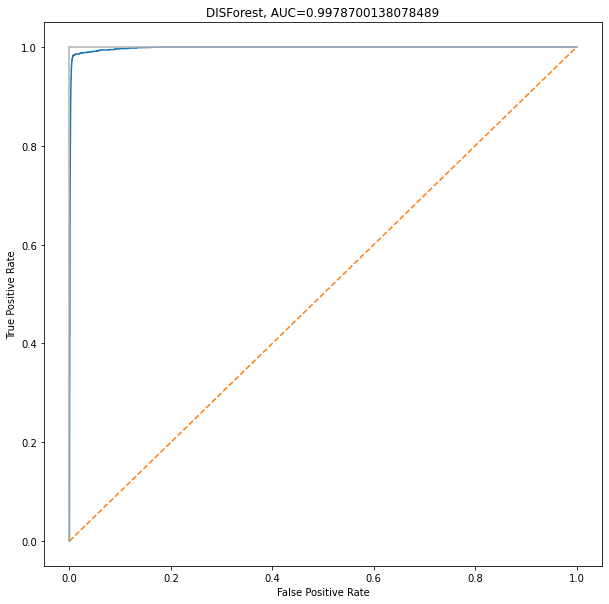

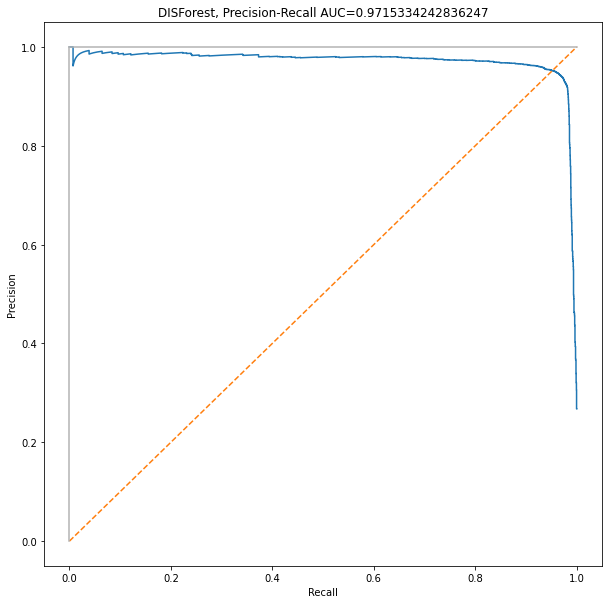

In [0]:
start_time = time.time()

dis_model = DIForest(100, 256).fit(spark, data)
predictions = dis_model.transform(spark, data)
predictions_df = predictions.select("attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "Y", "outlierScore", "predictedLabel").toPandas()
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("DISForest", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

### SKLearn - non distributed implemenation

In [0]:
non_distributed_data_df = data.toPandas()
non_distributed_data_df = non_distributed_data_df.drop("features", axis=1)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Execution time: 2.6113061904907227 seconds
Accuracy Score :
0.9592439456585942

Classification Report :
 precision recall f1-score support

 0 1.00 0.96 0.98 45586
 1 0.64 0.98 0.78 3511

 accuracy 0.96 49097
 macro avg 0.82 0.97 0.88 49097
weighted avg 0.97 0.96 0.96 49097


Confusion Matrix:
[[43640 1946]
 [ 55 3456]]

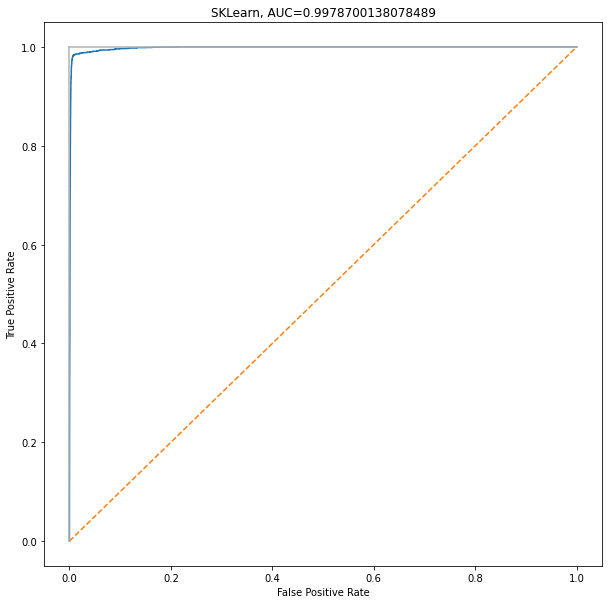

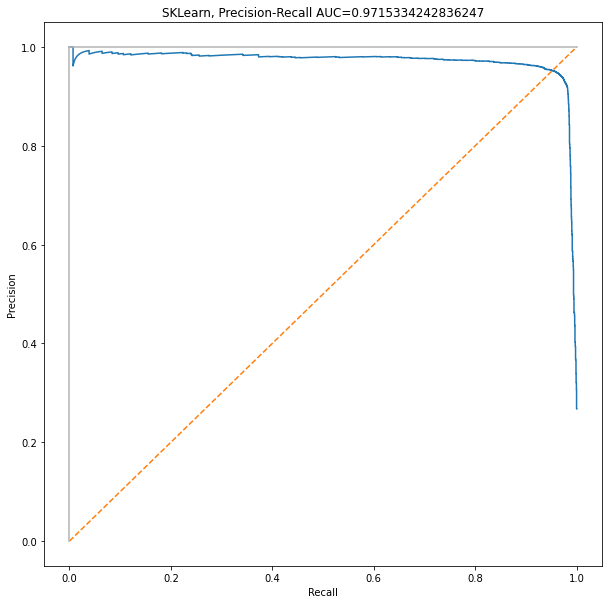

In [0]:
start_time = time.time()

# Init the model with default parameters
isolation_forest_model = SKLearnIsolationForest(n_estimators=100)

# Fit the model
isolation_forest_model.fit(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9"]])

# Predict
predictions = isolation_forest_model.predict(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9"]])
non_distributed_data_df['outlierScore'] = isolation_forest_model.score_samples(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9"]])
non_distributed_data_df["predictedLabel"] = np.where(predictions == 1, 0, 1)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SKLearn", non_distributed_data_df["Y"], non_distributed_data_df["predictedLabel"], predictions_df["outlierScore"])

### SynapseML

Execution time: 10.249976634979248 seconds
Accuracy Score :
0.9495895879585311

Classification Report :
 precision recall f1-score support

 0 0.95 1.00 0.97 45586
 1 1.00 0.30 0.46 3511

 accuracy 0.95 49097
 macro avg 0.97 0.65 0.71 49097
weighted avg 0.95 0.95 0.94 49097


Confusion Matrix:
[[45583 3]
 [ 2472 1039]]

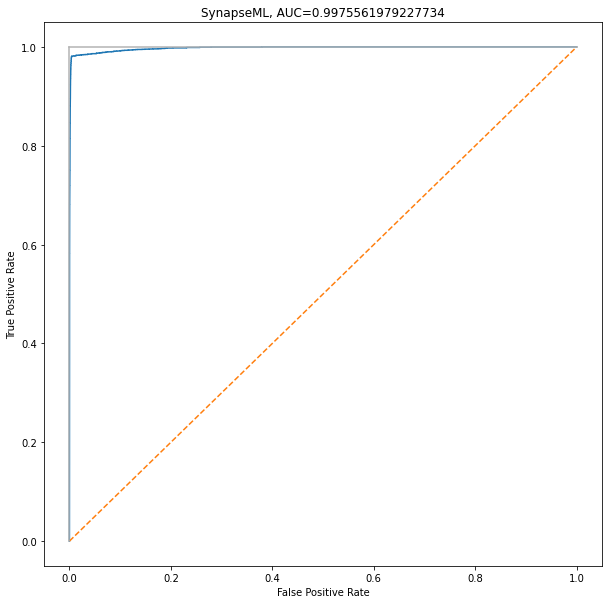

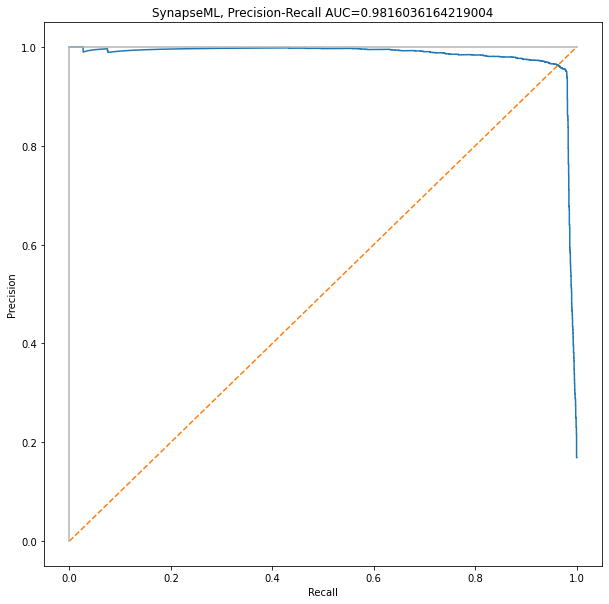

In [0]:
start_time = time.time()

# Init IsolationForest like in the SynapseML documentation
contamination = 0.021
num_estimators = 100
max_samples = 256
max_features = 1.0

isolationForest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)
model = isolationForest.fit(data)
predictions = model.transform(data)

predictions_df = predictions.select("attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "Y", "outlierScore", "predictedLabel").toPandas()

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SynapseML", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

## Annthyroid

In [0]:
data = spark.read.table("hive_metastore.default.annthyroid")
print("Schema:")
data.printSchema()
print()

samples_count = data.count()
outliers_count = data.where(data["Y"] == 1).count()

print("Count: ", samples_count)
print("Outliers: ", outliers_count)
print("Outliers percentage: ", outliers_count * 100 / samples_count, "%")

input_cols=["attr1", "attr2", "attr3", "attr4", "attr5", "attr6"]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)
data.show()

Schema:
root
-- attr1: double (nullable = true)
-- attr2: double (nullable = true)
-- attr3: double (nullable = true)
-- attr4: double (nullable = true)
-- attr5: double (nullable = true)
-- attr6: double (nullable = true)
-- Y: long (nullable = true)


Count: 7200
Outliers: 534
Outliers percentage: 7.416666666666667 %
+-----+-------+------+-----+-----+-------+---+--------------------+
attr1| attr2| attr3|attr4|attr5| attr6| Y| features|
+-----+-------+------+-----+-----+-------+---+--------------------+
 0.73| 6.0E-4| 0.015| 0.12|0.082| 0.146| 0|[0.73,6.0E-4,0.01...|
 0.24| 2.5E-4| 0.03|0.143|0.133| 0.108| 0|[0.24,2.5E-4,0.03...|
 0.47| 0.0019| 0.024|0.102|0.131| 0.078| 0|[0.47,0.0019,0.02...|
 0.64| 9.0E-4| 0.017|0.077| 0.09| 0.085| 0|[0.64,9.0E-4,0.01...|
 0.23| 2.5E-4| 0.026|0.139| 0.09| 0.153| 0|[0.23,2.5E-4,0.02...|
 0.69| 2.5E-4| 0.016|0.086| 0.07| 0.123| 0|[0.69,2.5E-4,0.01...|
 0.85| 2.5E-4| 0.023|0.128|0.104| 0.121| 0|[0.85,2.5E-4,0.02...|
 0.48|0.00208| 0.02|0.086|0.078| 0.11| 0|[0.48,0.00208,0.0...|
 0.67| 0.0013| 0.024|0.087|0.109| 0.08| 0|[0.67,0.0013,0.02...|
 0.76| 1.0E-4| 0.029|0.124|0.128| 0.097| 0|[0.76,1.0E-4,0.02...|
 0.62| 0.011| 0.008|0.073|0.074| 0.098| 1|[0.62,0.011,0.008...|
 0.18| 1.0E-4| 0.023|0.098|0.085| 0.115| 0|[0.18,1.0E-4,0.02...|
 0.59| 8.0E-4| 0.023|0.094|0.099|0.09475| 0|[0.59,8.0E-4,0.02...|
 0.49| 6.0E-4| 0.023|0.113|0.102| 0.111| 0|[0.49,6.0E-4,0.02...|
 0.53| 0.0023| 0.02|0.063|0.095| 0.066| 0|[0.53,0.0023,0.02...|
 0.39| 1.0E-4| 0.018| 0.09|0.071| 0.126| 0|[0.39,1.0E-4,0.01...|
 0.39| 6.0E-4| 0.02|0.114| 0.1| 0.114| 0|[0.39,6.0E-4,0.02...|
 0.65| 0.0016| 0.018|0.078|0.092| 0.085| 0|[0.65,0.0016,0.01...|
 0.64| 0.032| 0.014|0.085|0.116| 0.071| 0|[0.64,0.032,0.014...|
 0.5| 0.061|0.0096|0.013|0.116| 0.011| 1|[0.5,0.061,0.0096...|
+-----+-------+------+-----+-----+-------+---+--------------------+
only showing top 20 rows

### Our Implementation

Execution time: 5.722801685333252 seconds
Accuracy Score :
0.8865277777777778

Classification Report :
 precision recall f1-score support

 0 0.95 0.92 0.94 6666
 1 0.30 0.41 0.35 534

 accuracy 0.89 7200
 macro avg 0.63 0.67 0.64 7200
weighted avg 0.90 0.89 0.89 7200


Confusion Matrix:
[[6166 500]
 [ 317 217]]

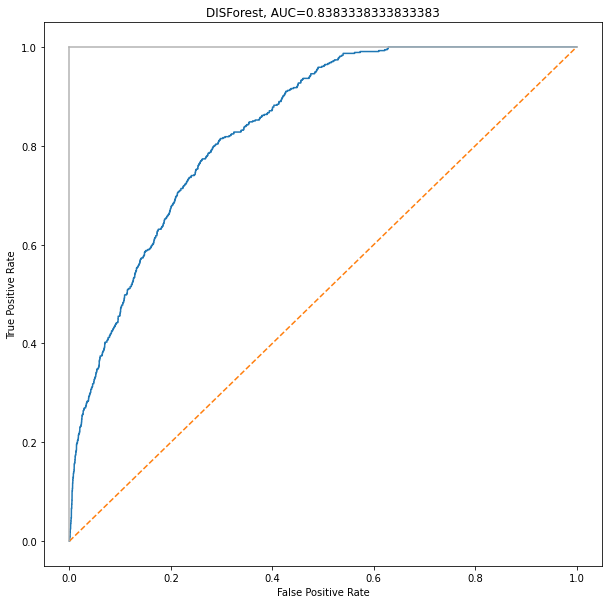

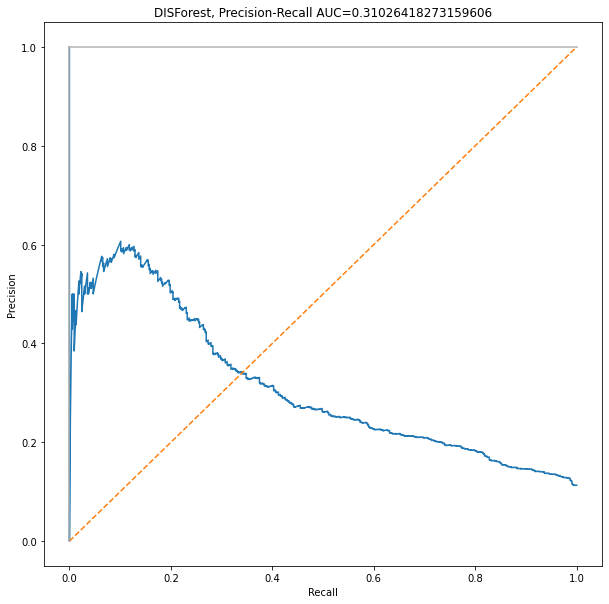

In [0]:
start_time = time.time()

dis_model = DIForest(100, 256).fit(spark, data)
predictions = dis_model.transform(spark, data)
predictions_df = predictions.select("attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "Y", "outlierScore", "predictedLabel").toPandas()
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("DISForest", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

### SKLearn - non distributed implemenation

In [0]:
non_distributed_data_df = data.toPandas()
non_distributed_data_df = non_distributed_data_df.drop("features", axis=1)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Execution time: 0.49352574348449707 seconds
Accuracy Score :
0.8866666666666667

Classification Report :
 precision recall f1-score support

 0 0.95 0.93 0.94 6666
 1 0.29 0.35 0.31 534

 accuracy 0.89 7200
 macro avg 0.62 0.64 0.63 7200
weighted avg 0.90 0.89 0.89 7200


Confusion Matrix:
[[6197 469]
 [ 347 187]]

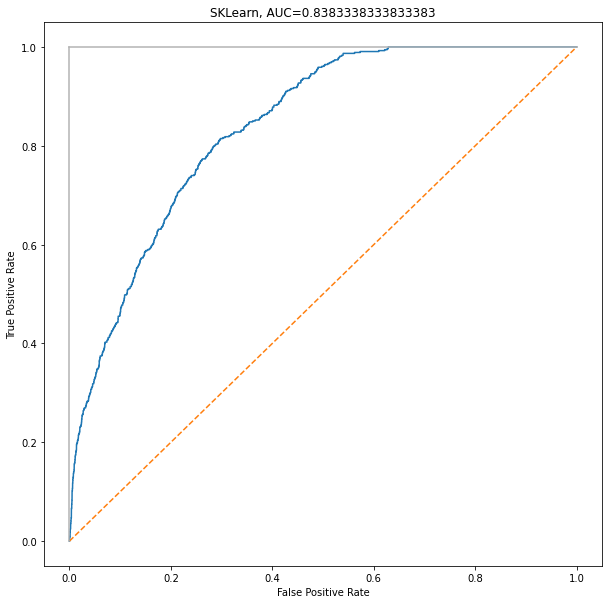

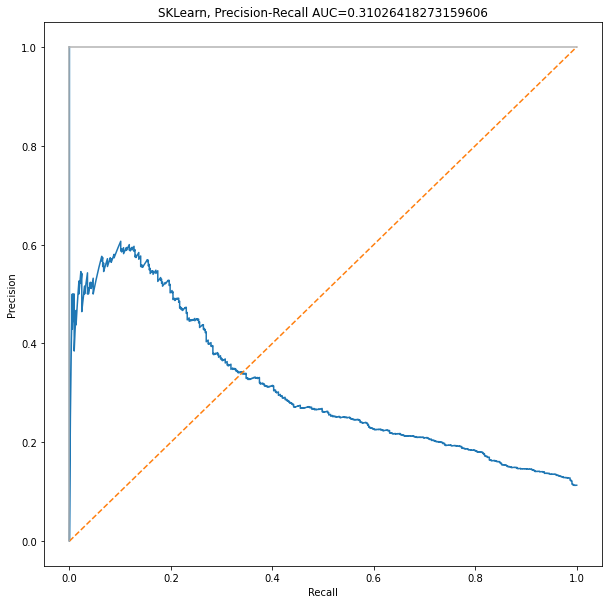

In [0]:
start_time = time.time()

# Init the model with default parameters
isolation_forest_model = SKLearnIsolationForest(n_estimators=100)

# Fit the model
isolation_forest_model.fit(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6"]])

# Predict
predictions = isolation_forest_model.predict(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6"]])
non_distributed_data_df['outlierScore'] = isolation_forest_model.score_samples(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6"]])
non_distributed_data_df["predictedLabel"] = np.where(predictions == 1, 0, 1)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SKLearn", non_distributed_data_df["Y"], non_distributed_data_df["predictedLabel"], predictions_df["outlierScore"])

### SynapseML

Execution time: 4.2248945236206055 seconds
Accuracy Score :
0.9275

Classification Report :
 precision recall f1-score support

 0 0.94 0.99 0.96 6666
 1 0.54 0.16 0.24 534

 accuracy 0.93 7200
 macro avg 0.74 0.57 0.60 7200
weighted avg 0.91 0.93 0.91 7200


Confusion Matrix:
[[6595 71]
 [ 451 83]]

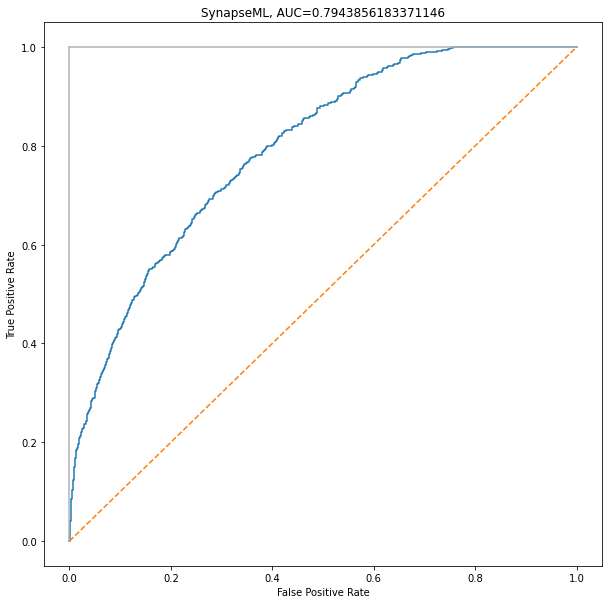

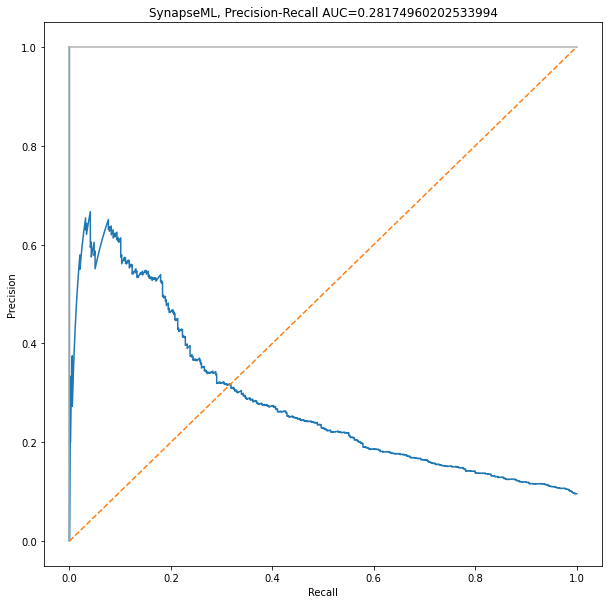

In [0]:
start_time = time.time()

# Init IsolationForest like in the SynapseML documentation
contamination = 0.021
num_estimators = 100
max_samples = 256
max_features = 1.0

isolationForest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)
model = isolationForest.fit(data)
predictions = model.transform(data)

predictions_df = predictions.select("attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "Y", "outlierScore", "predictedLabel").toPandas()

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SynapseML", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

## ForestCover

In [0]:
data = spark.read.table("hive_metastore.default.cover")
print("Schema:")
data.printSchema()
print()

samples_count = data.count()
outliers_count = data.where(data["Y"] == 1).count()

print("Count: ", samples_count)
print("Outliers: ", outliers_count)
print("Outliers percentage: ", outliers_count * 100 / samples_count, "%")

input_cols=["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "attr10"]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)
data.show()

Schema:
root
-- attr1: long (nullable = true)
-- attr2: long (nullable = true)
-- attr3: long (nullable = true)
-- attr4: long (nullable = true)
-- attr5: long (nullable = true)
-- attr6: long (nullable = true)
-- attr7: long (nullable = true)
-- attr8: long (nullable = true)
-- attr9: long (nullable = true)
-- attr10: long (nullable = true)
-- Y: long (nullable = true)


Count: 286048
Outliers: 2747
Outliers percentage: 0.9603283365029646 %
+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+---+--------------------+
attr1|attr2|attr3|attr4|attr5|attr6|attr7|attr8|attr9|attr10| Y| features|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+---+--------------------+
 2804| 139| 9| 268| 65| 3180| 234| 238| 135| 6121| 0|[2804.0,139.0,9.0...|
 2785| 155| 18| 242| 118| 3090| 238| 238| 122| 6211| 0|[2785.0,155.0,18....|
 2579| 132| 6| 300| -15| 67| 230| 237| 140| 6031| 0|[2579.0,132.0,6.0...|
 2886| 151| 11| 371| 26| 5253| 234| 240| 136| 4051| 0|[2886.0,151.0,11....|
 2742| 134| 22| 150| 69| 3215| 248| 224| 92| 6091| 0|[2742.0,134.0,22....|
 2880| 209| 17| 216| 30| 4986| 206| 253| 179| 4323| 0|[2880.0,209.0,17....|
 2962| 148| 16| 323| 23| 5916| 240| 236| 120| 3395| 0|[2962.0,148.0,16....|
 2811| 135| 1| 212| 30| 3670| 220| 238| 154| 5643| 0|[2811.0,135.0,1.0...|
 2900| 45| 19| 242| 20| 5199| 221| 195| 100| 4115| 0|[2900.0,45.0,19.0...|
 2570| 346| 2| 0| 0| 331| 215| 235| 158| 5745| 0|[2570.0,346.0,2.0...|
 2678| 128| 5| 95| 23| 1660| 229| 236| 141| 6546| 0|[2678.0,128.0,5.0...|
 2952| 107| 11| 42| 7| 5845| 239| 226| 116| 3509| 0|[2952.0,107.0,11....|
 2705| 90| 8| 134| 22| 2023| 232| 228| 129| 6615| 0|[2705.0,90.0,8.0,...|
 2740| 54| 6| 218| 42| 2287| 224| 227| 138| 6686| 0|[2740.0,54.0,6.0,...|
 2640| 80| 8| 180| -2| 1092| 231| 225| 127| 5866| 0|[2640.0,80.0,8.0,...|
 2843| 166| 12| 242| 53| 4434| 230| 244| 144| 4956| 0|[2843.0,166.0,12....|
 3008| 45| 14| 277| 10| 6371| 223| 208| 116| 3036| 0|[3008.0,45.0,14.0...|
 2893| 114| 16| 108| 30| 5066| 245| 223| 102| 4340| 0|[2893.0,114.0,16....|
 2850| 6| 9| 0| 0| 4858| 210| 223| 151| 4548| 0|[2850.0,6.0,9.0,0...|
 2628| 30| 10| 240| 19| 960| 217| 218| 136| 5645| 0|[2628.0,30.0,10.0...|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+---+--------------------+
only showing top 20 rows

### Our Implementation

Execution time: 121.12582588195801 seconds
Accuracy Score :
0.842047488533393

Classification Report :
 precision recall f1-score support

 0 1.00 0.84 0.91 283301
 1 0.04 0.68 0.08 2747

 accuracy 0.84 286048
 macro avg 0.52 0.76 0.50 286048
weighted avg 0.99 0.84 0.91 286048


Confusion Matrix:
[[238990 44311]
 [ 871 1876]]

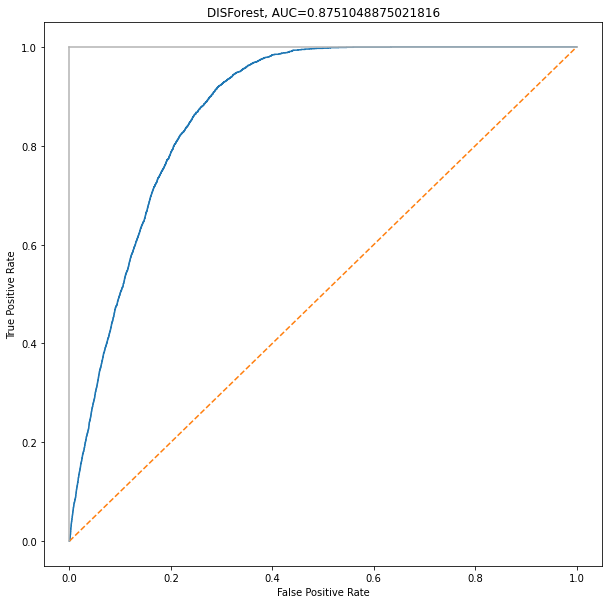

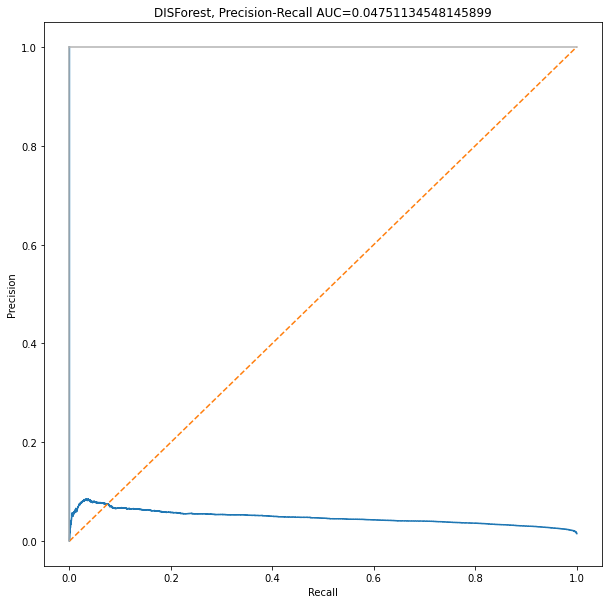

In [0]:
start_time = time.time()

dis_model = DIForest(100, 256).fit(spark, data)
predictions = dis_model.transform(spark, data)
predictions_df = predictions.select("attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "attr10", "Y", "outlierScore", "predictedLabel").toPandas()
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("DISForest", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

### SKLearn - non distributed implementation

In [0]:
non_distributed_data_df = data.toPandas()
non_distributed_data_df = non_distributed_data_df.drop("features", axis=1)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Execution time: 12.100350856781006 seconds
Accuracy Score :
0.850608988701197

Classification Report :
 precision recall f1-score support

 0 1.00 0.85 0.92 283301
 1 0.05 0.87 0.10 2747

 accuracy 0.85 286048
 macro avg 0.53 0.86 0.51 286048
weighted avg 0.99 0.85 0.91 286048


Confusion Matrix:
[[240925 42376]
 [ 357 2390]]

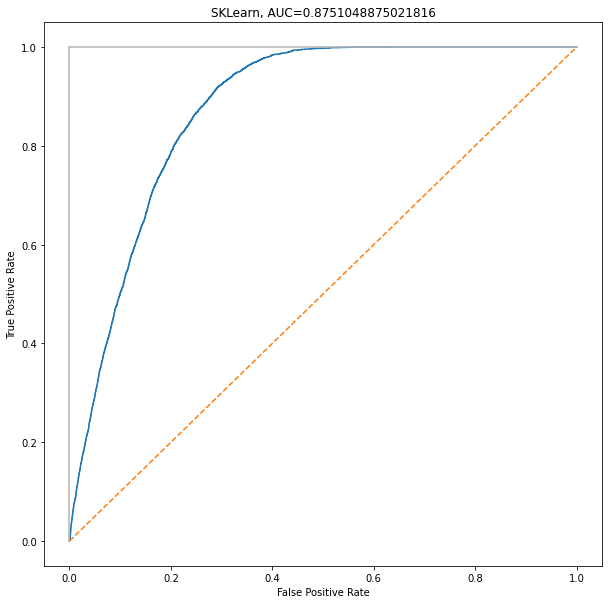

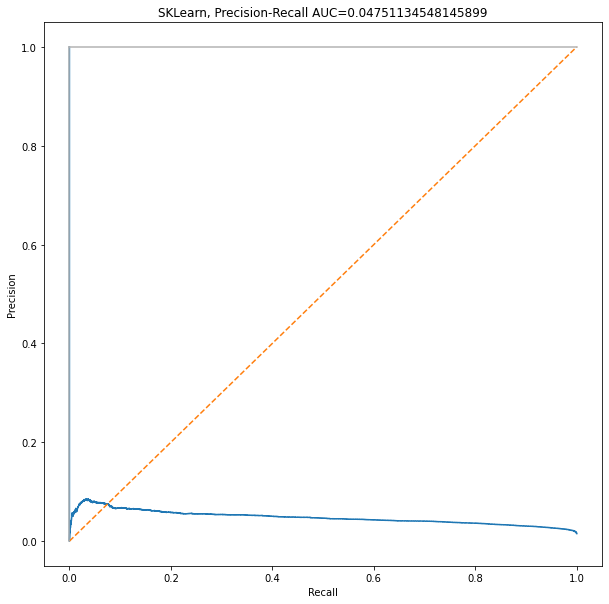

In [0]:
start_time = time.time()

# Init the model with default parameters
isolation_forest_model = SKLearnIsolationForest(n_estimators=100)

# Fit the model
isolation_forest_model.fit(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "attr10"]])

# Predict
predictions = isolation_forest_model.predict(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "attr10"]])
non_distributed_data_df['outlierScore'] = isolation_forest_model.score_samples(non_distributed_data_df[["attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "attr10"]])
non_distributed_data_df["predictedLabel"] = np.where(predictions == 1, 0, 1)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SKLearn", non_distributed_data_df["Y"], non_distributed_data_df["predictedLabel"], predictions_df["outlierScore"])

### SynapseML

Execution time: 37.69855856895447 seconds
Accuracy Score :
0.9720920964313682

Classification Report :
 precision recall f1-score support

 0 0.99 0.98 0.99 283301
 1 0.07 0.14 0.09 2747

 accuracy 0.97 286048
 macro avg 0.53 0.56 0.54 286048
weighted avg 0.98 0.97 0.98 286048


Confusion Matrix:
[[277671 5630]
 [ 2353 394]]

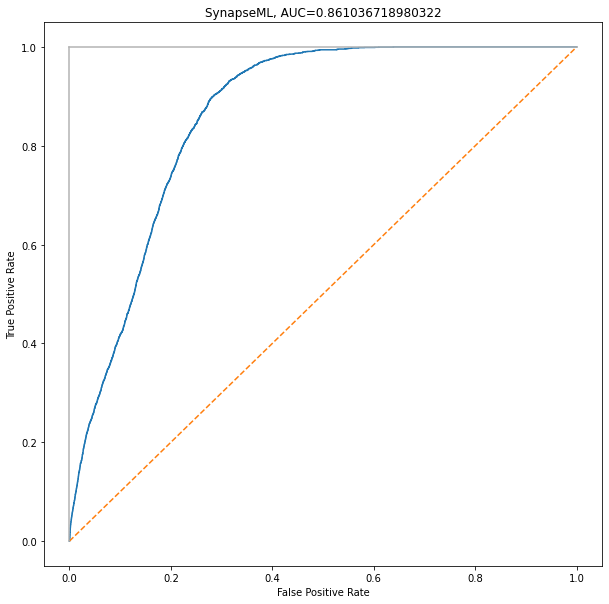

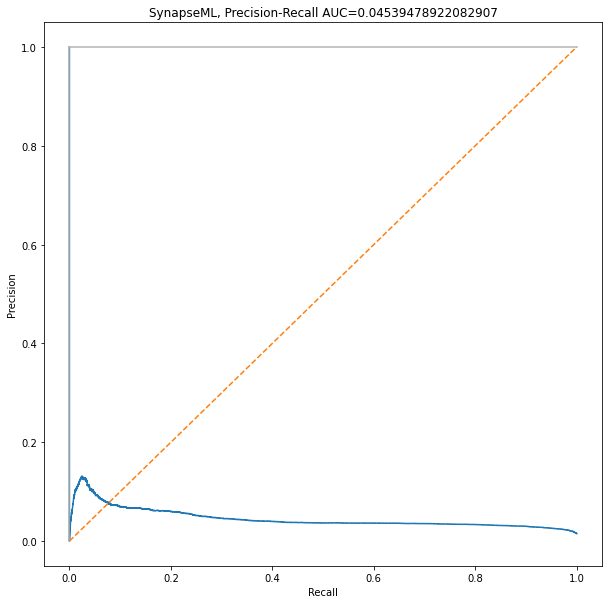

In [0]:
start_time = time.time()

# Init IsolationForest like in the SynapseML documentation
contamination = 0.021
num_estimators = 100
max_samples = 256
max_features = 1.0

isolationForest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)
model = isolationForest.fit(data)
predictions = model.transform(data)

predictions_df = predictions.select("attr1", "attr2", "attr3", "attr4", "attr5", "attr6", "attr7", "attr8", "attr9", "attr10", "Y", "outlierScore", "predictedLabel").toPandas()

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SynapseML", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

## Arrhythmia

In [0]:
data = spark.read.table("hive_metastore.default.arrhythmia")
print("Schema:")
data.printSchema()
print()

samples_count = data.count()
outliers_count = data.where(data["Y"] == 1).count()

print("Count: ", samples_count)
print("Outliers: ", outliers_count)
print("Outliers percentage: ", outliers_count * 100 / samples_count, "%")

input_cols=[f"attr{i}" for i in range(274)]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)
data.show()

Schema:
root
-- attr0: double (nullable = true)
-- attr1: double (nullable = true)
-- attr2: double (nullable = true)
-- attr3: double (nullable = true)
-- attr4: double (nullable = true)
-- attr5: double (nullable = true)
-- attr6: double (nullable = true)
-- attr7: double (nullable = true)
-- attr8: double (nullable = true)
-- attr9: double (nullable = true)
-- attr10: double (nullable = true)
-- attr11: double (nullable = true)
-- attr12: double (nullable = true)
-- attr13: double (nullable = true)
-- attr14: double (nullable = true)
-- attr15: double (nullable = true)
-- attr16: double (nullable = true)
-- attr17: double (nullable = true)
-- attr18: double (nullable = true)
-- attr19: double (nullable = true)
-- attr20: double (nullable = true)
-- attr21: double (nullable = true)
-- attr22: double (nullable = true)
-- attr23: double (nullable = true)
-- attr24: double (nullable = true)
-- attr25: double (nullable = true)
-- attr26: double (nullable = true)
-- attr27: double (nullable = true)
-- attr28: double (nullable = true)
-- attr29: double (nullable = true)
-- attr30: double (nullable = true)
-- attr31: double (nullable = true)
-- attr32: double (nullable = true)
-- attr33: double (nullable = true)
-- attr34: double (nullable = true)
-- attr35: double (nullable = true)
-- attr36: double (nullable = true)
-- attr37: double (nullable = true)
-- attr38: double (nullable = true)
-- attr39: double (nullable = true)
-- attr40: double (nullable = true)
-- attr41: double (nullable = true)
-- attr42: double (nullable = true)
-- attr43: double (nullable = true)
-- attr44: double (nullable = true)
-- attr45: double (nullable = true)
-- attr46: double (nullable = true)
-- attr47: double (nullable = true)
-- attr48: double (nullable = true)
-- attr49: double (nullable = true)
-- attr50: double (nullable = true)
-- attr51: double (nullable = true)
-- attr52: double (nullable = true)
-- attr53: double (nullable = true)
-- attr54: double (nullable = true)
-- attr55: double (nullable = true)
-- attr56: double (nullable = true)
-- attr57: double (nullable = true)
-- attr58: double (nullable = true)
-- attr59: double (nullable = true)
-- attr60: double (nullable = true)
-- attr61: double (nullable = true)
-- attr62: double (nullable = true)
-- attr63: double (nullable = true)
-- attr64: double (nullable = true)
-- attr65: double (nullable = true)
-- attr66: double (nullable = true)
-- attr67: double (nullable = true)
-- attr68: double (nullable = true)
-- attr69: double (nullable = true)
-- attr70: double (nullable = true)
-- attr71: double (nullable = true)
-- attr72: double (nullable = true)
-- attr73: double (nullable = true)
-- attr74: double (nullable = true)
-- attr75: double (nullable = true)
-- attr76: double (nullable = true)
-- attr77: double (nullable = true)
-- attr78: double (nullable = true)
-- attr79: double (nullable = true)
-- attr80: double (nullable = true)
-- attr81: double (nullable = true)
-- attr82: double (nullable = true)
-- attr83: double (nullable = true)
-- attr84: double (nullable = true)
-- attr85: double (nullable = true)
-- attr86: double (nullable = true)
-- attr87: double (nullable = true)
-- attr88: double (nullable = true)
-- attr89: double (nullable = true)
-- attr90: double (nullable = true)
-- attr91: double (nullable = true)
-- attr92: double (nullable = true)
-- attr93: double (nullable = true)
-- attr94: double (nullable = true)
-- attr95: double (nullable = true)
-- attr96: double (nullable = true)
-- attr97: double (nullable = true)
-- attr98: double (nullable = true)
-- attr99: double (nullable = true)
-- attr100: double (nullable = true)
-- attr101: double (nullable = true)
-- attr102: double (nullable = true)
-- attr103: double (nullable = true)
-- attr104: double (nullable = true)
-- attr105: double (nullable = true)
-- attr106: double (nullable = true)
-- attr107: double (nullable = true)
-- attr108: double (nullable = true)
-- attr109: double (nullable = true)
-- attr110: double (nullabl

### Our Implementation

Execution time: 10.936042070388794 seconds
Accuracy Score :
0.4026548672566372

Classification Report :
 precision recall f1-score support

 0 0.87 0.35 0.50 386
 1 0.15 0.68 0.25 66

 accuracy 0.40 452
 macro avg 0.51 0.52 0.38 452
weighted avg 0.76 0.40 0.47 452


Confusion Matrix:
[[137 249]
 [ 21 45]]

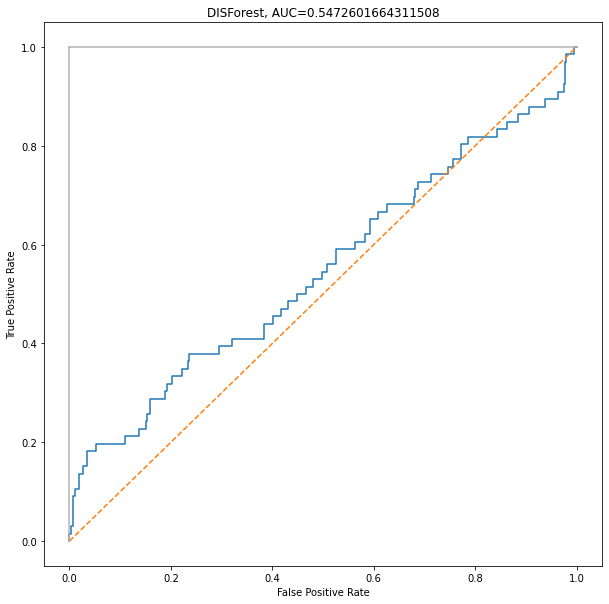

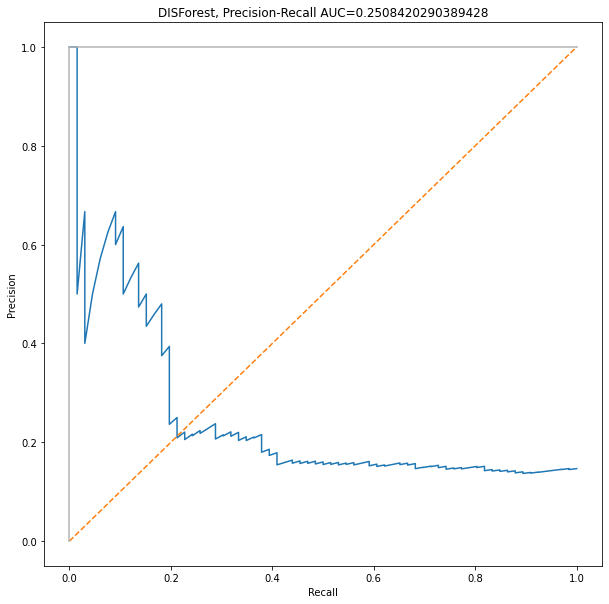

In [0]:
start_time = time.time()

dis_model = DIForest(100, 256).fit(spark, data)
predictions = dis_model.transform(spark, data)
predictions_columns = input_cols + ["Y", "outlierScore", "predictedLabel"]
predictions_df = predictions.select(*predictions_columns).toPandas()
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("DISForest", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

### SKLearn - non distributed implementation

In [0]:
non_distributed_data_df = data.toPandas()
non_distributed_data_df = non_distributed_data_df.drop("features", axis=1)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Execution time: 0.3017909526824951 seconds
Accuracy Score :
0.8628318584070797

Classification Report :
 precision recall f1-score support

 0 0.87 0.99 0.92 386
 1 0.67 0.12 0.21 66

 accuracy 0.86 452
 macro avg 0.77 0.56 0.57 452
weighted avg 0.84 0.86 0.82 452


Confusion Matrix:
[[382 4]
 [ 58 8]]

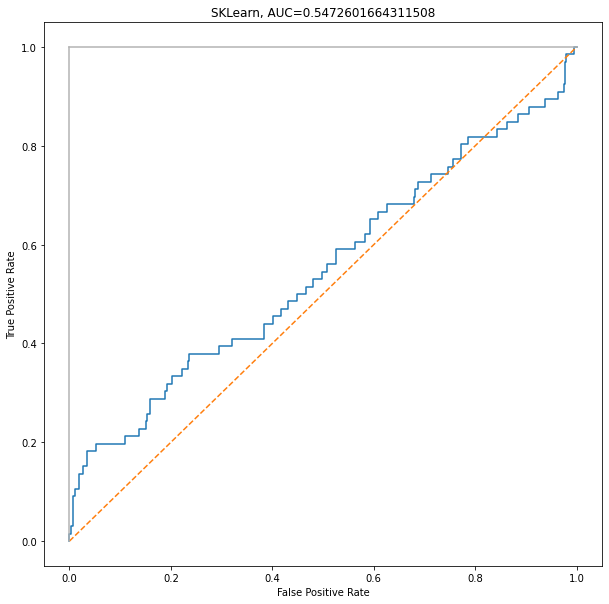

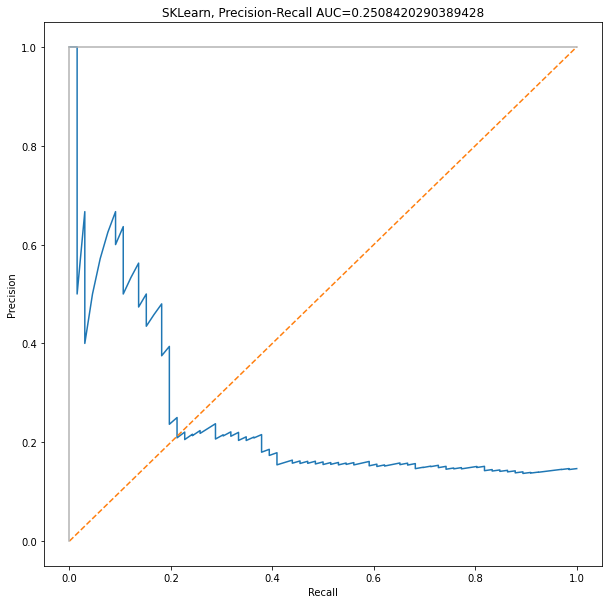

In [0]:
start_time = time.time()

# Init the model with default parameters
isolation_forest_model = SKLearnIsolationForest(n_estimators=100)

# Fit the model
isolation_forest_model.fit(non_distributed_data_df[input_cols])

# Predict
predictions = isolation_forest_model.predict(non_distributed_data_df[input_cols])
non_distributed_data_df['outlierScore'] = isolation_forest_model.score_samples(non_distributed_data_df[input_cols])
non_distributed_data_df["predictedLabel"] = np.where(predictions == 1, 0, 1)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SKLearn", non_distributed_data_df["Y"], non_distributed_data_df["predictedLabel"], predictions_df["outlierScore"])

### SynapseML

Execution time: 7.739501476287842 seconds
Accuracy Score :
0.8628318584070797

Classification Report :
 precision recall f1-score support

 0 0.87 0.99 0.93 386
 1 0.70 0.11 0.18 66

 accuracy 0.86 452
 macro avg 0.78 0.55 0.55 452
weighted avg 0.84 0.86 0.82 452


Confusion Matrix:
[[383 3]
 [ 59 7]]

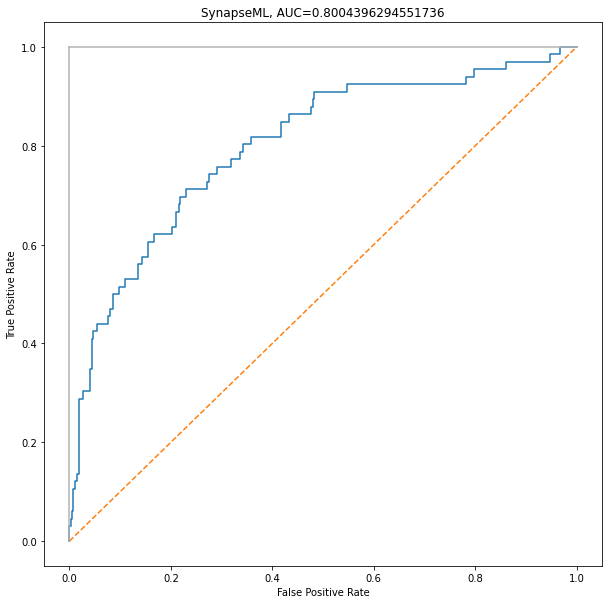

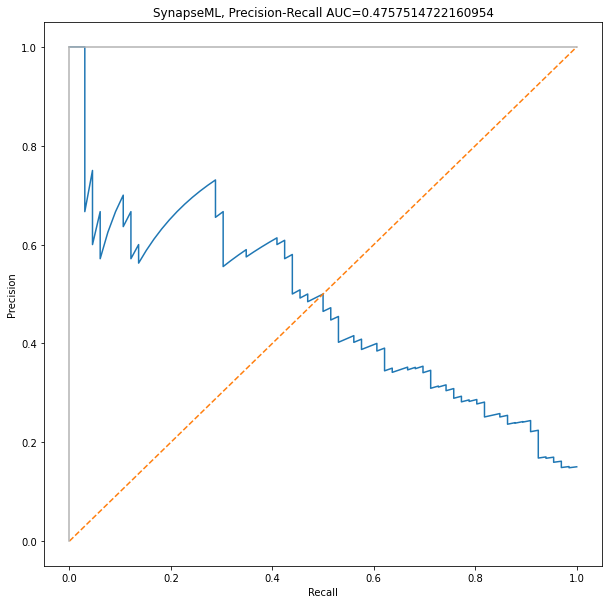

In [0]:
start_time = time.time()

# Init IsolationForest like in the SynapseML documentation
contamination = 0.021
num_estimators = 100
max_samples = 256
max_features = 1.0

isolationForest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)
model = isolationForest.fit(data)
predictions = model.transform(data)

predictions_columns = input_cols + ["Y", "outlierScore", "predictedLabel"]
predictions_df = predictions.select(*predictions_columns).toPandas()

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SynapseML", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

## Particle

In [0]:
data = spark.read.table("hive_metastore.default.particle_preproc_csv")
data=data.withColumnRenamed("ground.truth", "ground_truth")
data=data.withColumnRenamed("point.id", "point_id")
data=data.withColumnRenamed("original.label", "original_label")
data=data.withColumnRenamed("V", "V.0")
data = data.withColumn('Y',F.when(data.ground_truth == "anomaly", 1).otherwise(0))

for i in range(50):
    data = data.withColumnRenamed(f"V.{i}", f"V_{i}")

print("Schema:")
data.printSchema()
print()

samples_count = data.count()
outliers_count = data.where(data["Y"] == 1).count()

print("Count: ", samples_count)
print("Outliers: ", outliers_count)
print("Outliers percentage: ", outliers_count * 100 / samples_count, "%")

input_cols=[f"V_{i}" for i in range(50)]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)
data.show()

Schema:
root
-- point_id: string (nullable = true)
-- motherset: string (nullable = true)
-- origin: string (nullable = true)
-- original_label: integer (nullable = true)
-- ground_truth: string (nullable = true)
-- V_0: double (nullable = true)
-- V_1: double (nullable = true)
-- V_2: double (nullable = true)
-- V_3: double (nullable = true)
-- V_4: double (nullable = true)
-- V_5: double (nullable = true)
-- V_6: double (nullable = true)
-- V_7: double (nullable = true)
-- V_8: double (nullable = true)
-- V_9: double (nullable = true)
-- V_10: double (nullable = true)
-- V_11: double (nullable = true)
-- V_12: double (nullable = true)
-- V_13: double (nullable = true)
-- V_14: double (nullable = true)
-- V_15: double (nullable = true)
-- V_16: double (nullable = true)
-- V_17: double (nullable = true)
-- V_18: double (nullable = true)
-- V_19: double (nullable = true)
-- V_20: double (nullable = true)
-- V_21: double (nullable = true)
-- V_22: double (nullable = true)
-- V_23: double (nullable = true)
-- V_24: double (nullable = true)
-- V_25: double (nullable = true)
-- V_26: double (nullable = true)
-- V_27: double (nullable = true)
-- V_28: double (nullable = true)
-- V_29: double (nullable = true)
-- V_30: double (nullable = true)
-- V_31: double (nullable = true)
-- V_32: double (nullable = true)
-- V_33: double (nullable = true)
-- V_34: double (nullable = true)
-- V_35: double (nullable = true)
-- V_36: double (nullable = true)
-- V_37: double (nullable = true)
-- V_38: double (nullable = true)
-- V_39: double (nullable = true)
-- V_40: double (nullable = true)
-- V_41: double (nullable = true)
-- V_42: double (nullable = true)
-- V_43: double (nullable = true)
-- V_44: double (nullable = true)
-- V_45: double (nullable = true)
-- V_46: double (nullable = true)
-- V_47: double (nullable = true)
-- V_48: double (nullable = true)
-- V_49: double (nullable = true)
-- Y: integer (nullable = false)


Count: 130064
Outliers: 36499
Outliers percentage: 28.062338541025955 %
+--------------------+---------+------+--------------+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+---+--------------------+
 point_id|motherset|origin|original_label|ground_truth| V_0| V_1| V_2| V_3| V_4| V_5| V_6| V_7| V_8| V_9| V_10| V_11| V_12| V_13| V_14| V_15| V_16| V_17| V_18| V_19| V_20| V_21| V_22| V_23| V_24| V_25| V_26| V_27| V_28| V_29| V_30| V_31| V_32| V_33| V_34| V_35| V_36| V_37| V_38| V_39| V_40| V_41| V_42| V_43| V_44| V_45| V_46| V_47| V_48| V_49| Y| features|
+--------------------+---------+------+--------------+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------

### Our Implementation

Execution time: 23.182700872421265 seconds
Accuracy Score :
0.6916287366219708

Classification Report :
 precision recall f1-score support

 0 0.71 0.95 0.82 93565
 1 0.16 0.02 0.04 36499

 accuracy 0.69 130064
 macro avg 0.44 0.49 0.43 130064
weighted avg 0.56 0.69 0.60 130064


Confusion Matrix:
[[89102 4463]
 [35645 854]]

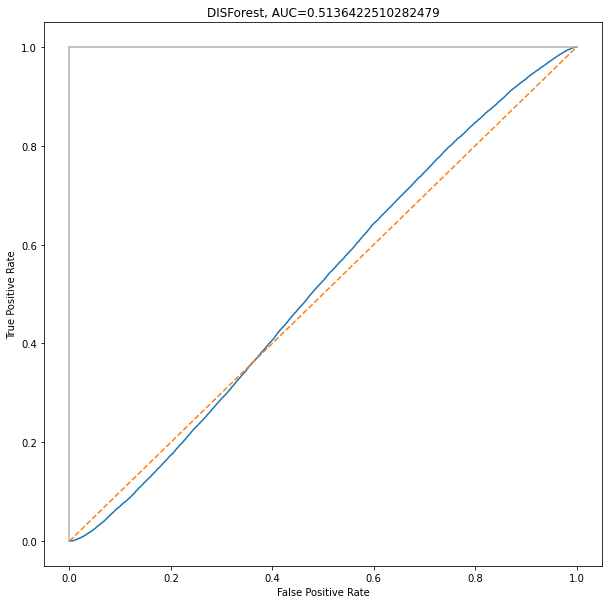

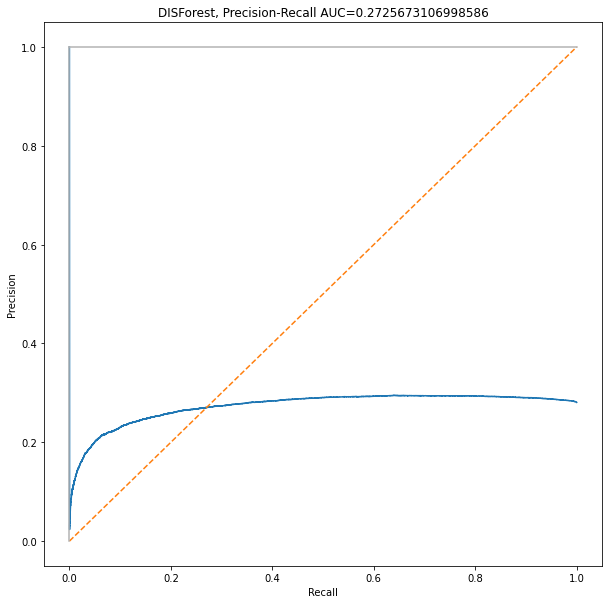

In [0]:
start_time = time.time()

dis_model = DIForest(100, 256).fit(spark, data)
predictions = dis_model.transform(spark, data)
predictions_columns = input_cols + ["Y", "outlierScore", "predictedLabel"]
predictions_df = predictions.select(*predictions_columns).toPandas()
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("DISForest", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

### SKLearn - non distributed implementation

In [0]:
non_distributed_data_df = data.toPandas()
non_distributed_data_df = non_distributed_data_df.drop("features", axis=1)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Execution time: 12.060850143432617 seconds
Accuracy Score :
0.6904677697133719

Classification Report :
 precision recall f1-score support

 0 0.71 0.95 0.82 93565
 1 0.12 0.02 0.03 36499

 accuracy 0.69 130064
 macro avg 0.42 0.49 0.42 130064
weighted avg 0.55 0.69 0.60 130064


Confusion Matrix:
[[89185 4380]
 [35879 620]]

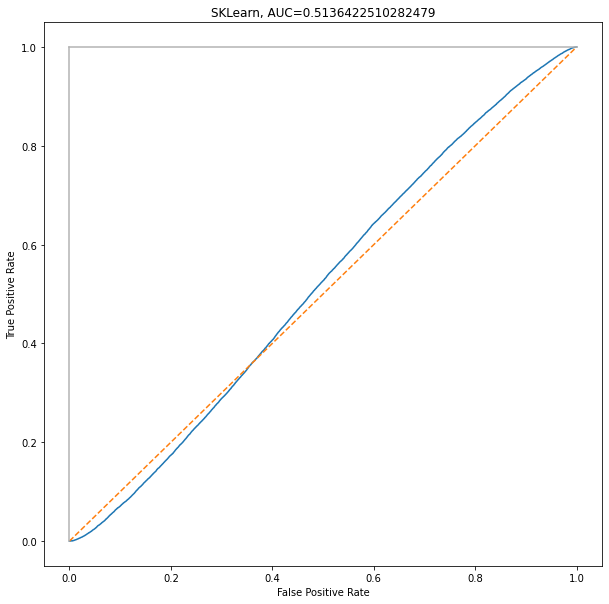

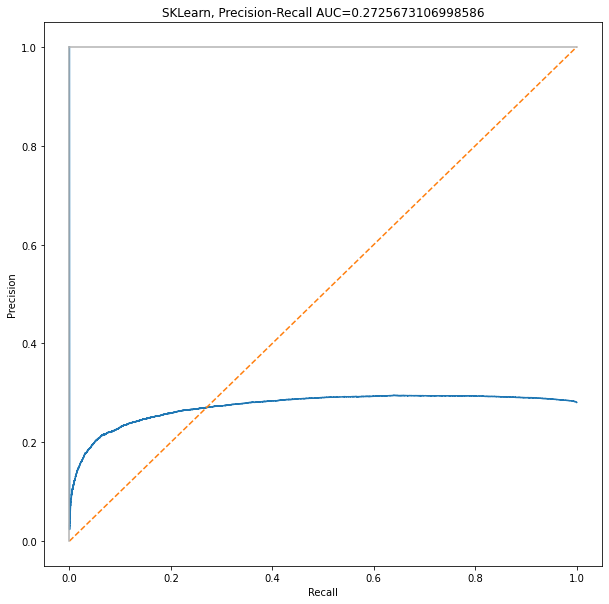

In [0]:
start_time = time.time()

# Init the model with default parameters
isolation_forest_model = SKLearnIsolationForest(n_estimators=100)

# Fit the model
isolation_forest_model.fit(non_distributed_data_df[input_cols])

# Predict
predictions = isolation_forest_model.predict(non_distributed_data_df[input_cols])
non_distributed_data_df['outlierScore'] = isolation_forest_model.score_samples(non_distributed_data_df[input_cols])
non_distributed_data_df["predictedLabel"] = np.where(predictions == 1, 0, 1)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SKLearn", non_distributed_data_df["Y"], non_distributed_data_df["predictedLabel"], predictions_df["outlierScore"])

### SynapseML

Execution time: 16.119905710220337 seconds
Accuracy Score :
0.7036382088817813

Classification Report :
 precision recall f1-score support

 0 0.72 0.97 0.83 93565
 1 0.13 0.01 0.02 36499

 accuracy 0.70 130064
 macro avg 0.42 0.49 0.42 130064
weighted avg 0.55 0.70 0.60 130064


Confusion Matrix:
[[91162 2403]
 [36143 356]]

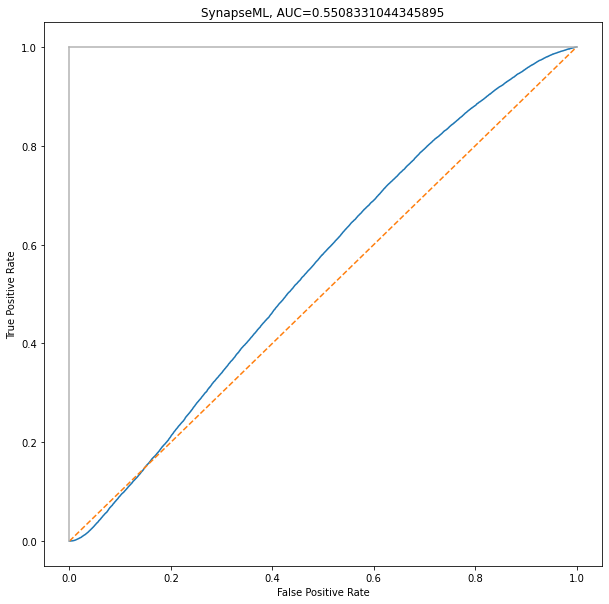

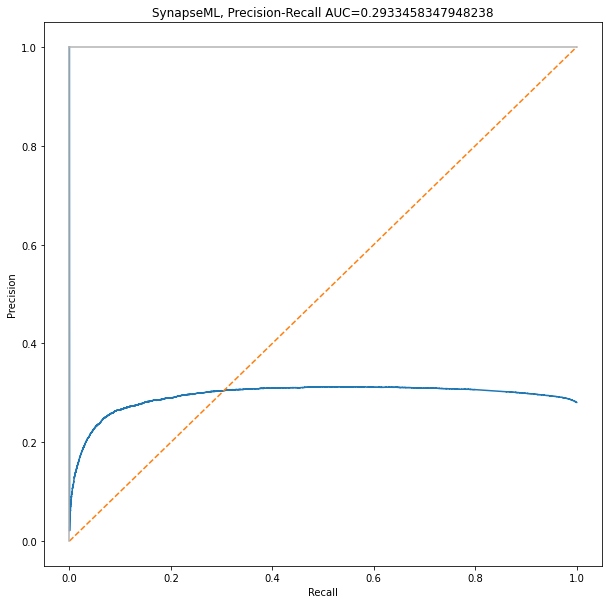

In [0]:
start_time = time.time()

# Init IsolationForest like in the SynapseML documentation
contamination = 0.021
num_estimators = 100
max_samples = 256
max_features = 1.0

isolationForest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)
model = isolationForest.fit(data)
predictions = model.transform(data)

predictions_columns = input_cols + ["Y", "outlierScore", "predictedLabel"]
predictions_df = predictions.select(*predictions_columns).toPandas()

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SynapseML", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

## YearP

In [0]:
data = spark.read.table("hive_metastore.default.yearp")
data=data.withColumnRenamed("ground.truth", "ground_truth")
data=data.withColumnRenamed("point.id", "point_id")
data=data.withColumnRenamed("original.label", "original_label")
data=data.withColumnRenamed("V", "V.0")
data = data.withColumn('Y',F.when(data.ground_truth == "anomaly", 1).otherwise(0))

for i in range(90):
    data = data.withColumnRenamed(f"V.{i}", f"V_{i}")

print("Schema:")
data.printSchema()
print()

samples_count = data.count()
outliers_count = data.where(data["Y"] == 1).count()

print("Count: ", samples_count)
print("Outliers: ", outliers_count)
print("Outliers percentage: ", outliers_count * 100 / samples_count, "%")

input_cols=[f"V_{i}" for i in range(90)]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)
data.show()

Schema:
root
-- point_id: string (nullable = true)
-- motherset: string (nullable = true)
-- origin: string (nullable = true)
-- original_label: integer (nullable = true)
-- ground_truth: string (nullable = true)
-- V_0: double (nullable = true)
-- V_1: double (nullable = true)
-- V_2: double (nullable = true)
-- V_3: double (nullable = true)
-- V_4: double (nullable = true)
-- V_5: double (nullable = true)
-- V_6: double (nullable = true)
-- V_7: double (nullable = true)
-- V_8: double (nullable = true)
-- V_9: double (nullable = true)
-- V_10: double (nullable = true)
-- V_11: double (nullable = true)
-- V_12: double (nullable = true)
-- V_13: double (nullable = true)
-- V_14: double (nullable = true)
-- V_15: double (nullable = true)
-- V_16: double (nullable = true)
-- V_17: double (nullable = true)
-- V_18: double (nullable = true)
-- V_19: double (nullable = true)
-- V_20: double (nullable = true)
-- V_21: double (nullable = true)
-- V_22: double (nullable = true)
-- V_23: double (nullable = true)
-- V_24: double (nullable = true)
-- V_25: double (nullable = true)
-- V_26: double (nullable = true)
-- V_27: double (nullable = true)
-- V_28: double (nullable = true)
-- V_29: double (nullable = true)
-- V_30: double (nullable = true)
-- V_31: double (nullable = true)
-- V_32: double (nullable = true)
-- V_33: double (nullable = true)
-- V_34: double (nullable = true)
-- V_35: double (nullable = true)
-- V_36: double (nullable = true)
-- V_37: double (nullable = true)
-- V_38: double (nullable = true)
-- V_39: double (nullable = true)
-- V_40: double (nullable = true)
-- V_41: double (nullable = true)
-- V_42: double (nullable = true)
-- V_43: double (nullable = true)
-- V_44: double (nullable = true)
-- V_45: double (nullable = true)
-- V_46: double (nullable = true)
-- V_47: double (nullable = true)
-- V_48: double (nullable = true)
-- V_49: double (nullable = true)
-- V_50: double (nullable = true)
-- V_51: double (nullable = true)
-- V_52: double (nullable = true)
-- V_53: double (nullable = true)
-- V_54: double (nullable = true)
-- V_55: double (nullable = true)
-- V_56: double (nullable = true)
-- V_57: double (nullable = true)
-- V_58: double (nullable = true)
-- V_59: double (nullable = true)
-- V_60: double (nullable = true)
-- V_61: double (nullable = true)
-- V_62: double (nullable = true)
-- V_63: double (nullable = true)
-- V_64: double (nullable = true)
-- V_65: double (nullable = true)
-- V_66: double (nullable = true)
-- V_67: double (nullable = true)
-- V_68: double (nullable = true)
-- V_69: double (nullable = true)
-- V_70: double (nullable = true)
-- V_71: double (nullable = true)
-- V_72: double (nullable = true)
-- V_73: double (nullable = true)
-- V_74: double (nullable = true)
-- V_75: double (nullable = true)
-- V_76: double (nullable = true)
-- V_77: double (nullable = true)
-- V_78: double (nullable = true)
-- V_79: double (nullable = true)
-- V_80: double (nullable = true)
-- V_81: double (nullable = true)
-- V_82: double (nullable = true)
-- V_83: double (nullable = true)
-- V_84: double (nullable = true)
-- V_85: double (nullable = true)
-- V_86: double (nullable = true)
-- V_87: double (nullable = true)
-- V_88: double (nullable = true)
-- V_89: double (nullable = true)
-- Y: integer (nullable = false)


Count: 515345
Outliers: 244074
Outliers percentage: 47.36128224781457 %
+------------------+---------+----------+--------------+------------+-------------------+-------------------+-------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------

### Our Implementation

Execution time: 48.14049959182739 seconds
Accuracy Score :
0.5293948713968313

Classification Report :
 precision recall f1-score support

 0 0.53 0.96 0.68 271271
 1 0.53 0.06 0.10 244074

 accuracy 0.53 515345
 macro avg 0.53 0.51 0.39 515345
weighted avg 0.53 0.53 0.41 515345


Confusion Matrix:
[[259283 11988]
 [230536 13538]]

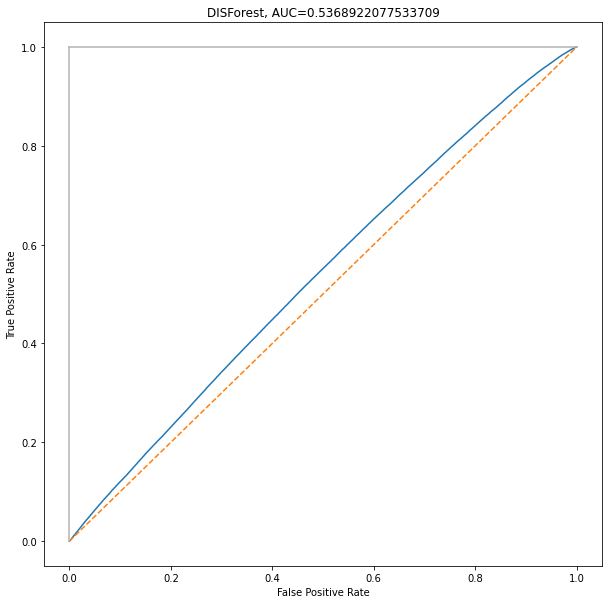

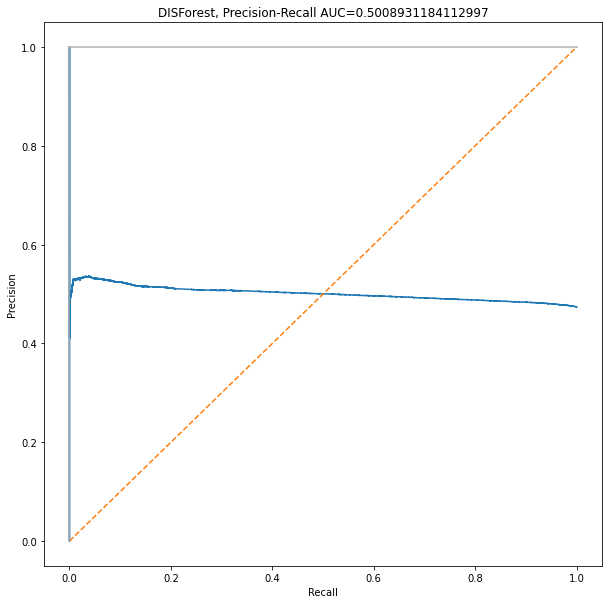

In [0]:
start_time = time.time()

dis_model = DIForest(100, 256).fit(spark, data)
predictions = dis_model.transform(spark, data)
predictions_columns = input_cols + ["Y", "outlierScore", "predictedLabel"]
predictions_df = predictions.select(*predictions_columns).toPandas()
end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("DISForest", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])

### SKLearn - non distributed algorithm

In [0]:
non_distributed_data_df = data.toPandas()
non_distributed_data_df = non_distributed_data_df.drop("features", axis=1)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Execution time: 90.84889483451843 seconds
Accuracy Score :
0.530308822245292

Classification Report :
 precision recall f1-score support

 0 0.53 0.96 0.68 271271
 1 0.54 0.05 0.10 244074

 accuracy 0.53 515345
 macro avg 0.54 0.51 0.39 515345
weighted avg 0.54 0.53 0.41 515345


Confusion Matrix:
[[260138 11133]
 [230920 13154]]

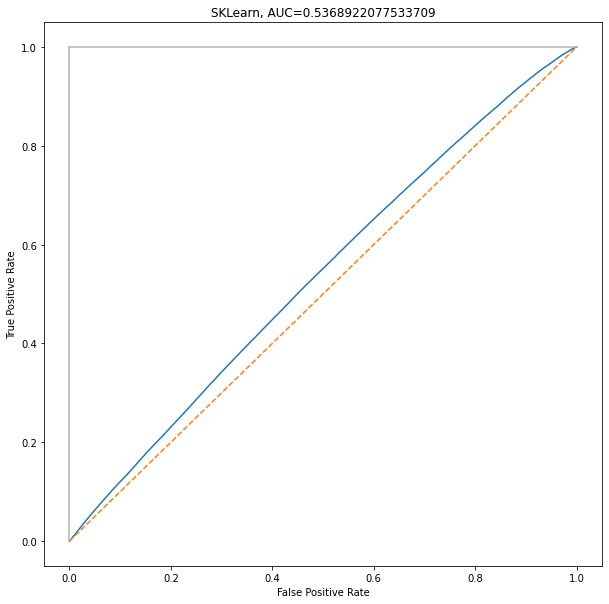

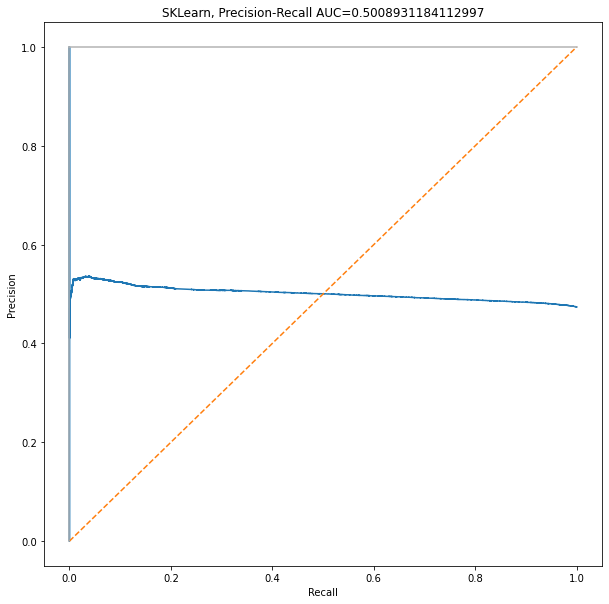

In [0]:
start_time = time.time()

# Init the model with default parameters
isolation_forest_model = SKLearnIsolationForest(n_estimators=100)

# Fit the model
isolation_forest_model.fit(non_distributed_data_df[input_cols])

# Predict
predictions = isolation_forest_model.predict(non_distributed_data_df[input_cols])
non_distributed_data_df['outlierScore'] = isolation_forest_model.score_samples(non_distributed_data_df[input_cols])
non_distributed_data_df["predictedLabel"] = np.where(predictions == 1, 0, 1)

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SKLearn", non_distributed_data_df["Y"], non_distributed_data_df["predictedLabel"], predictions_df["outlierScore"])

### SynapseML

Execution time: 55.35612106323242 seconds
Accuracy Score :
0.5281064141497444

Classification Report :
 precision recall f1-score support

 0 0.53 0.98 0.69 271271
 1 0.54 0.02 0.05 244074

 accuracy 0.53 515345
 macro avg 0.53 0.50 0.37 515345
weighted avg 0.53 0.53 0.38 515345


Confusion Matrix:
[[266268 5003]
 [238185 5889]]

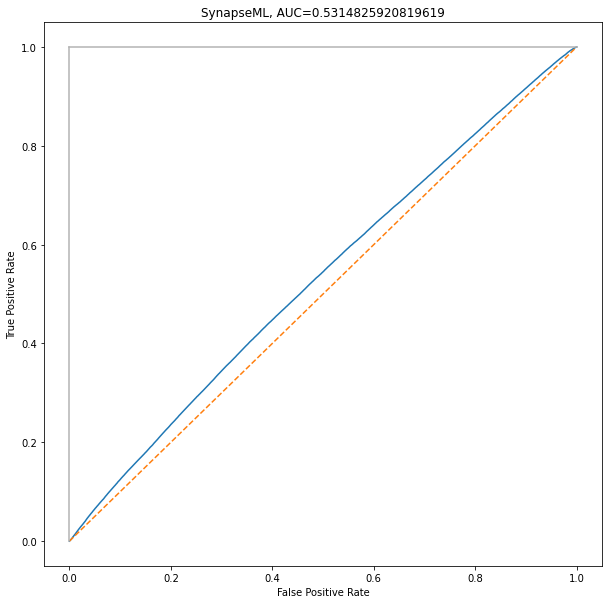

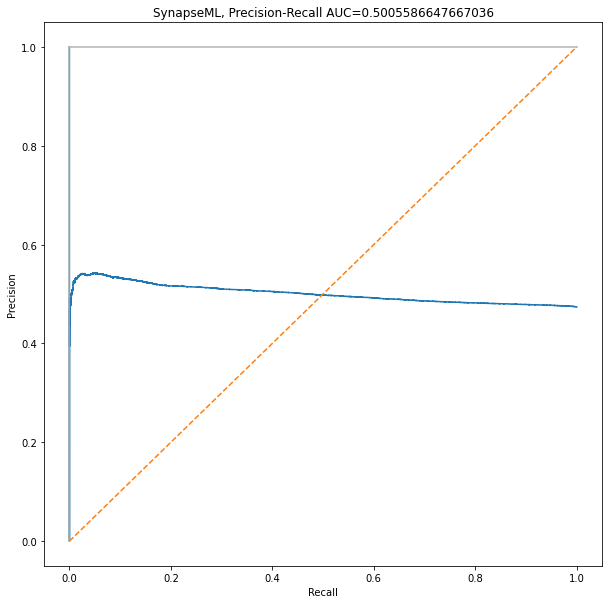

In [0]:
start_time = time.time()

# Init IsolationForest like in the SynapseML documentation
contamination = 0.021
num_estimators = 100
max_samples = 256
max_features = 1.0

isolationForest = (
    IsolationForest()
    .setNumEstimators(num_estimators)
    .setMaxSamples(max_samples)
    .setFeaturesCol("features")
    .setPredictionCol("predictedLabel")
    .setScoreCol("outlierScore")
    .setContamination(contamination)
    .setContaminationError(0.01 * contamination)
    .setRandomSeed(1)
)
model = isolationForest.fit(data)
predictions = model.transform(data)

predictions_columns = input_cols + ["Y", "outlierScore", "predictedLabel"]
predictions_df = predictions.select(*predictions_columns).toPandas()

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

evaluate_model("SynapseML", predictions_df["Y"], predictions_df["predictedLabel"], predictions_df["outlierScore"])